Stock investing Example, application of the reduction property

In [1]:
#%load_ext autoreload
#%autoreload 2
import numpy as np
import copy 
import random
import pandas as pd
from tqdm import tqdm
from scipy.stats import binom
from scipy.optimize import minimize
import matplotlib.pyplot as plt

C:\Users\Cecile\AppData\Local\Temp\ipykernel_17308\3441751006.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import yfinance as yf
import itertools

In [3]:
rng = np.random.default_rng()

In [4]:
from robust_q_learning_v2 import *
from q_learning import *

Importation of market data from yahoo finance

In [5]:
# AAPL_data  = yf.download("AAPL", start="2010-01-02", end="2021-01-01")
# MSFT_data  = yf.download("MSFT", start="2010-01-02", end="2021-01-01")
# GOOGL_data = yf.download("GOOGL", start="2010-01-02", end="2021-01-01")
# EBAY_data  = yf.download("EBAY", start="2010-01-02", end="2021-01-01")
# AMZN_data  = yf.download("AMZN", start="2010-01-02", end="2021-01-01")
# TSLA_data  = yf.download("TSLA", start="2010-01-02", end="2024-01-01")

data = yf.download("GOOGL", start="2010-01-02", end="2024-01-01")

[*********************100%%**********************]  1 of 1 completed


Computation of the return of the stock selected

In [6]:
small_return = 0.01
null_return  = 0.001
ind_0     = ((np.diff(data["Close"])/(data["Close"])[:-1])<null_return)&((np.diff(data["Close"])/(data["Close"])[:-1])>-null_return)
ind_0_pos = ((np.diff(data["Close"])/(data["Close"])[:-1])<small_return)&((np.diff(data["Close"])/(data["Close"])[:-1])>=null_return)
ind_pos   = ((np.diff(data["Close"])/(data["Close"])[:-1])>=small_return)
ind_0_neg = ((np.diff(data["Close"])/(data["Close"])[:-1])<=-null_return)&((np.diff(data["Close"])/(data["Close"])[:-1])>-small_return)
ind_neg   = ((np.diff(data["Close"])/(data["Close"])[:-1])<= - small_return)

returns = np.zeros(len(data)-1)
returns[ind_0]     = 0
returns[ind_0_pos] = 1
returns[ind_pos]   = 2
returns[ind_0_neg] = -1
returns[ind_neg]   = -2

Definition of training and testing periods

In [7]:
training_start = 1_000
training_end   = 1_500
returns_train_1  = returns[training_start:training_end]

training_start = 2_500
training_end   = 3_000
returns_train_2  = returns[training_start:training_end]

training_start = 3_000
training_end   = 3_500
returns_train_3  = returns[training_start:training_end]

#Testing Period
test_period_start = training_end+1
test_period_end = training_end+101
returns_test = returns[test_period_start:test_period_end]

Verification that the training periods correspond to really different periods

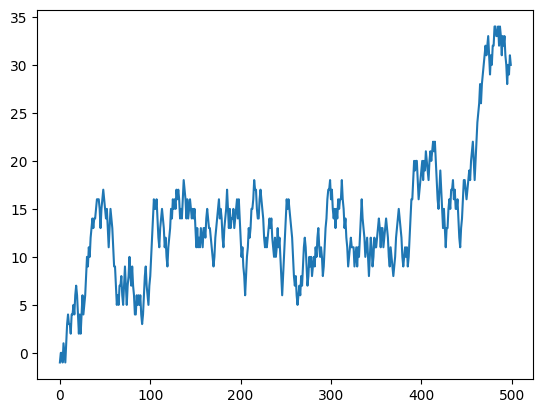

In [8]:
plt.plot(returns_train_1.cumsum())

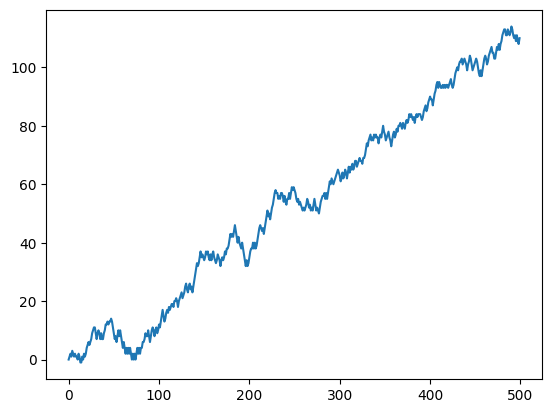

In [9]:
plt.plot(returns_train_2.cumsum())

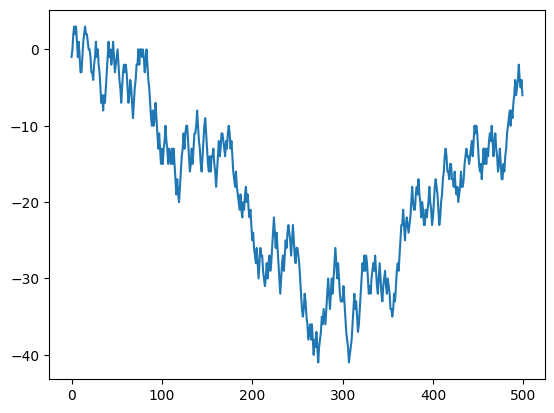

In [10]:
plt.plot(returns_train_3.cumsum())

In [11]:
h    = 3 # Length of history
ret1 = returns_train_1
ret2 = returns_train_2
ret3 = returns_train_3

#returns

Definition of the parameters to use the algorithm

In [12]:
# State Space
T = [-2, -1, 0, 1, 2]
X = np.array(list(itertools.product(T, repeat=h)))
#X

In [13]:
A = np.array([0, 1]) # Actions

def r(x,a,y):
    return 0.01 * a * y[-1]

eps_greedy = 0.1   # Epsilon greedy policy
alpha      = 0.95  # Discount Factor

#x_0        = 0     # Initial Value
rng  = np.random.default_rng()
x1_0 = rng.choice(np.array([ret1[i:(h+i)]  for i in range(len(ret1)-h-1)]),axis = 0)
x2_0 = rng.choice(np.array([ret2[i:(h+i)]  for i in range(len(ret2)-h-1)]),axis = 0)
x3_0 = rng.choice(np.array([ret3[i:(h+i)]  for i in range(len(ret3)-h-1)]),axis = 0)

k_0        = 0     # Initial index of the corresponding MDP, starting with the central proba of 1/2

In [14]:
# Build the functions that allow us to get the index of an element a (reps. x) in A (resp. X)
if np.ndim(A) > 1:
    A_list = A
else:
    A_list = np.array([[a] for a in A])
if np.ndim(X) > 1:
    X_list = X
else:
    X_list = np.array([[x] for x in X])

def a_index(a):
    return np.flatnonzero((a==A_list).all(1))[0]
def x_index(x):
    return np.flatnonzero((x==X_list).all(1))[0]

For each x, computation of the probabilities of occurence of the next return

In [15]:
p1_list = []
for x in X:
    eps = 1e-8
    x_u  = np.concatenate([x[1:], [2]])
    x_d  = np.concatenate([x[1:], [-2]])
    x_u0 = np.concatenate([x[1:], [1]])
    x_d0 = np.concatenate([x[1:], [-1]])    
    x_0  = np.concatenate([x[1:], [0]])
    p_u_raw  = np.sum([np.all(ret1[i:(h+i)]==x_u) for i in range(len(ret1)-h-1)])
    p_d_raw  = np.sum([np.all(ret1[i:(h+i)]==x_d) for i in range(len(ret1)-h-1)])
    p_u0_raw = np.sum([np.all(ret1[i:(h+i)]==x_u0) for i in range(len(ret1)-h-1)])
    p_d0_raw = np.sum([np.all(ret1[i:(h+i)]==x_d0) for i in range(len(ret1)-h-1)])
    p_0_raw  = np.sum([np.all(ret1[i:(h+i)]==x_0) for i in range(len(ret1)-h-1)])
    p_u  = (eps/5 + p_u_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + p_0_raw + eps)
    p_d  = (eps/5 + p_d_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + p_0_raw + eps)
    p_u0 = (eps/5 + p_u0_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + p_0_raw + eps)
    p_d0 = (eps/5 + p_d0_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + p_0_raw + eps)
    p_0  = (eps/5 + p_0_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + p_0_raw + eps)
    p1_list.append([p_d, p_d0, p_0, p_u0, p_u])

p2_list = []
for x in X:
    eps = 1e-8
    x_u  = np.concatenate([x[1:], [2]])
    x_d  = np.concatenate([x[1:], [-2]])
    x_u0 = np.concatenate([x[1:], [1]])
    x_d0 = np.concatenate([x[1:], [-1]])    
    x_0  = np.concatenate([x[1:], [0]])
    p_u_raw  = np.sum([np.all(ret2[i:(h+i)]==x_u) for i in range(len(ret2)-h-1)])
    p_d_raw  = np.sum([np.all(ret2[i:(h+i)]==x_d) for i in range(len(ret2)-h-1)])
    p_u0_raw = np.sum([np.all(ret2[i:(h+i)]==x_u0) for i in range(len(ret2)-h-1)])
    p_d0_raw = np.sum([np.all(ret2[i:(h+i)]==x_d0) for i in range(len(ret2)-h-1)])
    p_0_raw  = np.sum([np.all(ret2[i:(h+i)]==x_0) for i in range(len(ret2)-h-1)])
    p_u  = (eps/5 + p_u_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + p_0_raw + eps)
    p_d  = (eps/5 + p_d_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + p_0_raw + eps)
    p_u0 = (eps/5 + p_u0_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + p_0_raw + eps)
    p_d0 = (eps/5 + p_d0_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + p_0_raw + eps)
    p_0  = (eps/5 + p_0_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + p_0_raw + eps)
    p2_list.append([p_d, p_d0, p_0, p_u0, p_u])

p3_list = []
for x in X:
    eps = 1e-8
    x_u  = np.concatenate([x[1:], [2]])
    x_d  = np.concatenate([x[1:], [-2]])
    x_u0 = np.concatenate([x[1:], [1]])
    x_d0 = np.concatenate([x[1:], [-1]])    
    x_0  = np.concatenate([x[1:], [0]])
    p_u_raw  = np.sum([np.all(ret3[i:(h+i)]==x_u) for i in range(len(ret3)-h-1)])
    p_d_raw  = np.sum([np.all(ret3[i:(h+i)]==x_d) for i in range(len(ret3)-h-1)])
    p_u0_raw = np.sum([np.all(ret3[i:(h+i)]==x_u0) for i in range(len(ret3)-h-1)])
    p_d0_raw = np.sum([np.all(ret3[i:(h+i)]==x_d0) for i in range(len(ret3)-h-1)])
    p_0_raw  = np.sum([np.all(ret3[i:(h+i)]==x_0) for i in range(len(ret3)-h-1)])
    p_u  = (eps/5 + p_u_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + p_0_raw + eps)
    p_d  = (eps/5 + p_d_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + p_0_raw + eps)
    p_u0 = (eps/5 + p_u0_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + p_0_raw + eps)
    p_d0 = (eps/5 + p_d0_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + p_0_raw + eps)
    p_0  = (eps/5 + p_0_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + p_0_raw + eps)
    p3_list.append([p_d, p_d0, p_0, p_u0, p_u])

Construction of the worst case probability

In [16]:
p_list_worse = []
for i in range(len(X)):
    eps  = 1e-8
    #diff = 1e-2
    p1_d, p1_d0, p1_0, p1_u0, p1_u = p1_list[i]
    p2_d, p2_d0, p2_0, p2_u0, p2_u = p2_list[i]
    p3_d, p3_d0, p3_0, p3_u0, p3_u = p3_list[i]

    p_d_raw  = max(0, p1_d, p2_d, p3_d)
    p_d0_raw = max(0, (p1_d+p1_d0-p_d_raw), (p2_d+p2_d0-p_d_raw), (p3_d+p3_d0-p_d_raw))
    p_0_raw  = max(0, (p1_d+p1_d0+p1_0-p_d_raw-p_d0_raw), (p2_d+p2_d0+p2_0-p_d_raw-p_d0_raw), (p3_d+p3_d0+p3_0-p_d_raw-p_d0_raw))
    p_u0_raw = max(0, (p1_d+p1_d0+p1_0+p1_u0-p_d_raw-p_d0_raw-p_0_raw), (p2_d+p2_d0+p2_0+p2_u0-p_d_raw-p_d0_raw-p_0_raw), (p3_d+p3_d0+p3_0+p3_u0-p_d_raw-p_d0_raw-p_0_raw))
    p_u_raw  = max(0, (p1_d+p1_d0+p1_0+p1_u0+p1_u-p_d_raw-p_d0_raw-p_0_raw-p_u0_raw), (p2_d+p2_d0+p2_0+p2_u0+p2_u-p_d_raw-p_d0_raw-p_0_raw-p_u0_raw), (p3_d+p3_d0+p3_0+p3_u0+p3_u-p_d_raw-p_d0_raw-p_0_raw-p_u0_raw))
    #p_d_raw  = max(p1_d, p2_d, p3_d) + diff
    #p_d0_raw = max(p1_d0, p2_d0, p3_d0) + diff
    #p_u0_raw = min(p1_u0, p2_u0, p3_u0) - diff
    #p_u_raw  = min(p1_u, p2_u, p3_u) - diff
    #p_0_raw  = 1 - (p_d_raw + p_d0_raw + p_u0_raw + p_u_raw)
    p_u  = (eps/5 + p_u_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + p_0_raw + eps)
    p_d  = (eps/5 + p_d_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + p_0_raw + eps)
    p_u0 = (eps/5 + p_u0_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + p_0_raw + eps)
    p_d0 = (eps/5 + p_d0_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + p_0_raw + eps)
    p_0  = (eps/5 + p_0_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + p_0_raw + eps)
    p_list_worse.append([p_d, p_d0, p_0, p_u0, p_u])

In [17]:
p_list_worse_2 = []
for i in range(len(X)):
    eps  = 1e-8
    #diff = 1e-2
    p1_d, p1_d0, p1_0, p1_u0, p1_u = p1_list[i]
    p2_d, p2_d0, p2_0, p2_u0, p2_u = p2_list[i]
    p3_d, p3_d0, p3_0, p3_u0, p3_u = p3_list[i]

    p_u_raw  = min(p1_u, p2_u, p3_u)
    p_u0_raw = min((p1_u+p1_u0), (p2_u+p2_u0), (p3_u+p3_u0)) - p_u_raw
    p_0_raw  = min((p1_u+p1_u0+p1_0), (p2_u+p2_u0+p2_0), (p3_u+p3_u0+p3_0)) - p_u_raw - p_u0_raw
    p_d0_raw = min((p1_u+p1_u0+p1_0+p1_d0), (p2_u+p2_u0+p2_0+p2_d0), (p3_u+p3_u0+p3_0+p3_d0)) - p_u_raw - p_u0_raw - p_0_raw
    p_d_raw  = min((p1_u+p1_u0+p1_0+p1_d0+p1_d), (p2_u+p2_u0+p2_0+p2_d0+p2_d), (p3_u+p3_u0+p3_0+p3_d0+p3_d)) - p_u_raw - p_u0_raw - p_0_raw - p_d0_raw
    #p_d_raw  = max(p1_d, p2_d, p3_d) + diff
    #p_d0_raw = max(p1_d0, p2_d0, p3_d0) + diff
    #p_u0_raw = min(p1_u0, p2_u0, p3_u0) - diff
    #p_u_raw  = min(p1_u, p2_u, p3_u) - diff
    #p_0_raw  = 1 - (p_d_raw + p_d0_raw + p_u0_raw + p_u_raw)
    p_u  = (eps/5 + p_u_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + p_0_raw + eps)
    p_d  = (eps/5 + p_d_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + p_0_raw + eps)
    p_u0 = (eps/5 + p_u0_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + p_0_raw + eps)
    p_d0 = (eps/5 + p_d0_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + p_0_raw + eps)
    p_0  = (eps/5 + p_0_raw) / (p_u_raw + p_d_raw + p_u0_raw + p_d0_raw + p_0_raw + eps)
    p_list_worse_2.append([p_d, p_d0, p_0, p_u0, p_u])

In [18]:
p_list_worse

[[0.29411764606228374,
  0.17254901992290145,
  0.04444444603456784,
  0.17777777800493832,
  0.31111110997530866],
 [0.3333333319555556,
  0.16666666701111113,
  0.06666666804444442,
  0.1333333340222222,
  0.29999999896666674],
 [0.3333333315555556,
  0.16666666731944443,
  2.249999998185093e-09,
  0.16666666731944443,
  0.3333333315555556],
 [0.2916666657118056,
  0.10833333428819444,
  0.040000001663999994,
  0.3599999983360001,
  0.20000000000000007],
 [0.38461538272189355,
  0.1570512824690787,
  0.08333333454861114,
  0.12500000078125,
  0.24999999947916668],
 [0.319999998752,
  0.080000001248,
  0.16000000041600002,
  0.23999999958400003,
  0.19999999999999996],
 [0.31249999880468754,
  0.2946428561927614,
  0.03571428741581634,
  0.17857142879336738,
  0.17857142879336732],
 [0.42857142595918374,
  0.28571428473469385,
  0.11904761991723359,
  0.04166666854513886,
  0.12500000084374996],
 [0.32258064389594177,
  0.225806451346514,
  0.12903225879708635,
  0.225806451346514,
  

In [19]:
p_list_worse_2

[[0.29411764606228363,
  0.17254901992290145,
  0.04444444603456784,
  0.17777777800493832,
  0.31111110997530866],
 [0.33333333195555565,
  0.16666666701111107,
  0.06666666804444442,
  0.13333333402222225,
  0.2999999989666667],
 [0.3333333315555556,
  0.16666666731944432,
  2.249999998185093e-09,
  0.16666666731944443,
  0.3333333315555556],
 [0.2916666657118058,
  0.10833333428819433,
  0.04000000166399994,
  0.35999999833600005,
  0.2],
 [0.3846153827218935,
  0.15705128246907876,
  0.08333333454861108,
  0.12500000078125,
  0.24999999947916668],
 [0.31999999875199986,
  0.08000000124800002,
  0.1600000004160001,
  0.2399999995840001,
  0.20000000000000007],
 [0.31249999880468765,
  0.29464285619276154,
  0.03571428741581628,
  0.17857142879336735,
  0.17857142879336735],
 [0.42857142595918385,
  0.28571428473469396,
  0.11904761991723356,
  0.041666668545138896,
  0.12500000084375001],
 [0.32258064389594165,
  0.22580645134651411,
  0.1290322587970864,
  0.22580645134651406,
  0.

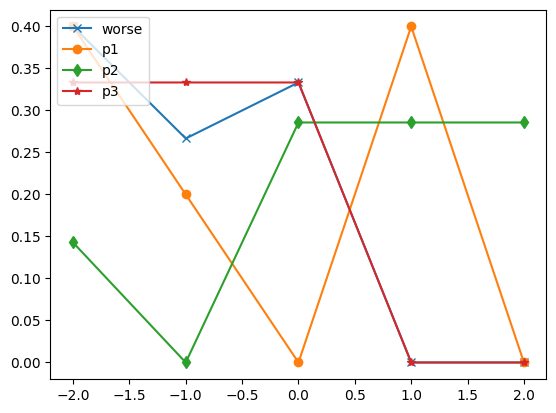

In [20]:
i  = 10
#X  = [-2, -1, 0, 1, 2]

plt.plot(T, p_list_worse[i], "-x", label = "worse")
plt.plot(T, p1_list[i], "-o", label="p1") 
plt.plot(T, p2_list[i], "-d", label="p2") 
plt.plot(T, p3_list[i], "-*", label="p3")
plt.legend(loc="upper left")
plt.show()

In [21]:
def p1(x, a, y):
    ind = np.flatnonzero((x_0==X).all(1))[0]
    p_d, p_d0, p_0, p_u0, p_u = p1_list[ind]
    return p_d * np.all(y==np.concatenate([x[1:],[-2]])) + p_d0*np.all(y==np.concatenate([x[1:],[-1]])) + p_0*np.all(y==np.concatenate([x[1:],[0]])) + p_u0*np.all(y==np.concatenate([x[1:],[1]])) + p_u*np.all(y==np.concatenate([x[1:],[2]]))

def P1(x,a):
    ind = np.flatnonzero((x_0==X).all(1))[0]
    p_d, p_d0, p_0, p_u0, p_u = p1_list[ind]
    rand_unif = (np.random.random_sample(size=1))
    rand = - 2*int(rand_unif < p_d) - 1*int((rand_unif >= (p_d)) * (rand_unif < (p_d+p_d0))) + 0*int((rand_unif >= (p_d+p_d0)) * (rand_unif < (p_d+p_d0+p_0))) + 1*int((rand_unif >= (p_d+p_d0+p_0)) * (rand_unif < (p_d+p_d0+p_0+p_u0))) + 2*int(rand_unif >= (p_d+p_d0+p_0+p_u0))
    return np.concatenate([x[1:],[rand]])

def p2(x, a, y):
    ind = np.flatnonzero((x_0==X).all(1))[0]
    p_d, p_d0, p_0, p_u0, p_u = p2_list[ind]
    return p_d * np.all(y==np.concatenate([x[1:],[-2]])) + p_d0*np.all(y==np.concatenate([x[1:],[-1]])) + p_0*np.all(y==np.concatenate([x[1:],[0]])) + p_u0*np.all(y==np.concatenate([x[1:],[1]])) + p_u*np.all(y==np.concatenate([x[1:],[2]]))

def P2(x,a):
    ind = np.flatnonzero((x_0==X).all(1))[0]
    p_d, p_d0, p_0, p_u0, p_u = p2_list[ind]
    rand_unif = (np.random.random_sample(size=1))
    rand = - 2*int(rand_unif < p_d) - 1*int((rand_unif >= (p_d)) * (rand_unif < (p_d+p_d0))) + 0*int((rand_unif >= (p_d+p_d0)) * (rand_unif < (p_d+p_d0+p_0))) + 1*int((rand_unif >= (p_d+p_d0+p_0)) * (rand_unif < (p_d+p_d0+p_0+p_u0))) + 2*int(rand_unif >= (p_d+p_d0+p_0+p_u0))
    return np.concatenate([x[1:],[rand]])

def p3(x, a, y):
    ind = np.flatnonzero((x_0==X).all(1))[0]
    p_d, p_d0, p_0, p_u0, p_u = p3_list[ind]
    return p_d * np.all(y==np.concatenate([x[1:],[-2]])) + p_d0*np.all(y==np.concatenate([x[1:],[-1]])) + p_0*np.all(y==np.concatenate([x[1:],[0]])) + p_u0*np.all(y==np.concatenate([x[1:],[1]])) + p_u*np.all(y==np.concatenate([x[1:],[2]]))

def P3(x,a):
    ind = np.flatnonzero((x_0==X).all(1))[0]
    p_d, p_d0, p_0, p_u0, p_u = p3_list[ind]
    rand_unif = (np.random.random_sample(size=1))
    rand = - 2*int(rand_unif < p_d) - 1*int((rand_unif >= (p_d)) * (rand_unif < (p_d+p_d0))) + 0*int((rand_unif >= (p_d+p_d0)) * (rand_unif < (p_d+p_d0+p_0))) + 1*int((rand_unif >= (p_d+p_d0+p_0)) * (rand_unif < (p_d+p_d0+p_0+p_u0))) + 2*int(rand_unif >= (p_d+p_d0+p_0+p_u0))
    return np.concatenate([x[1:],[rand]])


def p_worse(x, a, y):
    ind = np.flatnonzero((x_0==X).all(1))[0]
    p_d, p_d0, p_0, p_u0, p_u = p_list_worse[ind]
    return p_d * np.all(y==np.concatenate([x[1:],[-2]])) + p_d0*np.all(y==np.concatenate([x[1:],[-1]])) + p_0*np.all(y==np.concatenate([x[1:],[0]])) + p_u0*np.all(y==np.concatenate([x[1:],[1]])) + p_u*np.all(y==np.concatenate([x[1:],[2]]))

def P_worse(x,a):
    ind = np.flatnonzero((x_0==X).all(1))[0]
    p_d, p_d0, p_0, p_u0, p_u = p_list_worse[ind]
    rand_unif = (np.random.random_sample(size=1))
    rand = - 2*int(rand_unif < p_d) - 1*int((rand_unif >= (p_d)) * (rand_unif < (p_d+p_d0))) + 0*int((rand_unif >= (p_d+p_d0)) * (rand_unif < (p_d+p_d0+p_0))) + 1*int((rand_unif >= (p_d+p_d0+p_0)) * (rand_unif < (p_d+p_d0+p_0+p_u0))) + 2*int(rand_unif >= (p_d+p_d0+p_0+p_u0))
    return np.concatenate([x[1:],[rand]])

def p_worse2(x, a, y):
    ind = np.flatnonzero((x_0==X).all(1))[0]
    p_d, p_d0, p_0, p_u0, p_u = p_list_worse_2[ind]
    return p_d * np.all(y==np.concatenate([x[1:],[-2]])) + p_d0*np.all(y==np.concatenate([x[1:],[-1]])) + p_0*np.all(y==np.concatenate([x[1:],[0]])) + p_u0*np.all(y==np.concatenate([x[1:],[1]])) + p_u*np.all(y==np.concatenate([x[1:],[2]]))

def P_worse2(x,a):
    ind = np.flatnonzero((x_0==X).all(1))[0]
    p_d, p_d0, p_0, p_u0, p_u = p_list_worse_2[ind]
    rand_unif = (np.random.random_sample(size=1))
    rand = - 2*int(rand_unif < p_d) - 1*int((rand_unif >= (p_d)) * (rand_unif < (p_d+p_d0))) + 0*int((rand_unif >= (p_d+p_d0)) * (rand_unif < (p_d+p_d0+p_0))) + 1*int((rand_unif >= (p_d+p_d0+p_0)) * (rand_unif < (p_d+p_d0+p_0+p_u0))) + 2*int(rand_unif >= (p_d+p_d0+p_0+p_u0))
    return np.concatenate([x[1:],[rand]])

Running of the non-robust algorithm, by applying the Proposition 3.3

In [22]:
Nr_iter = 1_000_000
Q_0_1, V = q_learning(X, A, r, P_worse, alpha, x_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = 2*np.ones([len(X),len(A)]))#q_learning(X, A, r, MU_tilde, alpha, x_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))

  0%|          | 0/1000000 [00:00<?, ?it/s]C:\Users\Cecile\AppData\Local\Temp\ipykernel_17308\1657664502.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rand = - 2*int(rand_unif < p_d) - 1*int((rand_unif >= (p_d)) * (rand_unif < (p_d+p_d0))) + 0*int((rand_unif >= (p_d+p_d0)) * (rand_unif < (p_d+p_d0+p_0))) + 1*int((rand_unif >= (p_d+p_d0+p_0)) * (rand_unif < (p_d+p_d0+p_0+p_u0))) + 2*int(rand_unif >= (p_d+p_d0+p_0+p_u0))
100%|██████████| 1000000/1000000 [02:19<00:00, 7143.24it/s]


In [23]:
# Get the result of the Q-Learning algorithm,
# Get the optimal results for each x in X
def a_opt(t, Q_opt):
    return A[np.argmax(Q_opt[x_index(t),:])]

In [24]:
df1 = pd.DataFrame(np.array([[a_opt(x, Q_0_1) for x in X]]))
#df.columns = ['-2', '-1', '0', '1', '2']
df1

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
0,0,1,0,0,0,1,1,0,0,0,...,1,0,0,0,1,0,0,1,1,0


In [25]:
Nr_iter = 1_000_000
Q_0_2, V = q_learning(X, A, r, P_worse2, alpha, x_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = 2*np.ones([len(X),len(A)]))#q_learning(X, A, r, MU_tilde, alpha, x_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))
df2 = pd.DataFrame(np.array([[a_opt(x, Q_0_2) for x in X]]))
df2

  0%|          | 0/1000000 [00:00<?, ?it/s]C:\Users\Cecile\AppData\Local\Temp\ipykernel_17308\1657664502.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rand = - 2*int(rand_unif < p_d) - 1*int((rand_unif >= (p_d)) * (rand_unif < (p_d+p_d0))) + 0*int((rand_unif >= (p_d+p_d0)) * (rand_unif < (p_d+p_d0+p_0))) + 1*int((rand_unif >= (p_d+p_d0+p_0)) * (rand_unif < (p_d+p_d0+p_0+p_u0))) + 2*int(rand_unif >= (p_d+p_d0+p_0+p_u0))
100%|██████████| 1000000/1000000 [02:09<00:00, 7700.43it/s]


,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
0,0,1,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,1


Running the robust algorithm for comparison

In [26]:
Nr_iter = 1_000_000
Q_opt_robust, V = robust_q_learning_v2(X, A, r, np.array([P1, P2, P3, P_worse]), np.array([p1, p2, p3, p_worse]), alpha, x_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))
df_rob = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust) for x in X]]))
#df.columns = ['-2', '-1', '0', '1', '2']
df_rob

  0%|          | 0/1000000 [00:00<?, ?it/s]C:\Users\Cecile\AppData\Local\Temp\ipykernel_17308\1657664502.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rand = - 2*int(rand_unif < p_d) - 1*int((rand_unif >= (p_d)) * (rand_unif < (p_d+p_d0))) + 0*int((rand_unif >= (p_d+p_d0)) * (rand_unif < (p_d+p_d0+p_0))) + 1*int((rand_unif >= (p_d+p_d0+p_0)) * (rand_unif < (p_d+p_d0+p_0+p_u0))) + 2*int(rand_unif >= (p_d+p_d0+p_0+p_u0))
C:\Users\Cecile\AppData\Local\Temp\ipykernel_17308\1657664502.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rand = - 2*int(rand_unif < p_d) - 1*int((rand_unif >= (p_d)) * (rand_unif < (p_d+p_d0))) + 0*int((ran

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
0,1,0,0,1,1,0,0,0,0,1,...,1,1,0,1,1,1,1,1,0,1


Evaluation

In [44]:
test_returns = returns_train_3 #returns_train_2 #returns_train_3

X_t = np.array([test_returns[i:(h+i)]  for i in range(len(test_returns)-h-1)])
print("Test on Training Period:\n\nDays:             {}\nNegative Returns:   {}\nSmall Neg. Returns: {}\nNull Returns: {}\nSmall Pos. Returns: {}\nPositive Returns:   {}".format(len(test_returns),
                                                                            np.sum(test_returns==-2),
                                                                            np.sum(test_returns==-1),    
                                                                            np.sum(test_returns==0),                                         
                                                                            np.sum(test_returns==1),
                                                                            np.sum(test_returns==2)))
non_robust_rewards_1 = np.array([r(X_t[i],a_opt(X_t[i], Q_0_1),X_t[i+1]) for i in range(len(X_t)-1)])
non_robust_rewards_2 = np.array([r(X_t[i],a_opt(X_t[i], Q_0_2),X_t[i+1]) for i in range(len(X_t)-1)])
robust_rewards       = np.array([r(X_t[i],a_opt(X_t[i], Q_opt_robust),X_t[i+1]) for i in range(len(X_t)-1)])

print("Non-Robust 1:       {0:0.4f}% correct \nNon-Robust 2:       {0:0.4f}% correct \nRobust:           {1:0.4f}% correct ".format(100*np.sum(non_robust_rewards_1>0)/len(X_t),
                                                                                    100*np.sum(non_robust_rewards_2>0)/len(X_t),
                                                                                    100*np.sum(robust_rewards>0)/len(X_t)))

Test on Training Period:

Days:             500
Negative Returns:   145
Small Neg. Returns: 96
Null Returns: 24
Small Pos. Returns: 90
Positive Returns:   145
Non-Robust 1:       20.3629% correct 
Non-Robust 2:       20.3629% correct 
Robust:           18.9516% correct 


In [41]:
test_period_start = 0
test_period_end   = 1_000
returns_test      = returns[test_period_start:test_period_end]

In [45]:
test_returns1 = returns_test
X_t = np.array([test_returns1[i:(h+i)]  for i in range(len(test_returns1)-h-1)])
print("Test Period 1:\n\nDays:             {}\nNegative Returns:   {}\nSmall Neg. Returns: {}\nNull Returns: {}\nSmall Pos. Returns: {}\nPositive Returns:   {}".format(len(test_returns1),
                                                                            np.sum(test_returns1==-2),
                                                                            np.sum(test_returns1==-1),    
                                                                            np.sum(test_returns==0),                                             
                                                                            np.sum(test_returns1==1),
                                                                            np.sum(test_returns1==2)))
non_robust_rewards_1 = np.array([r(X_t[i],a_opt(X_t[i], Q_0_1),X_t[i+1]) for i in range(len(X_t)-1)])
non_robust_rewards_2 = np.array([r(X_t[i],a_opt(X_t[i], Q_0_2),X_t[i+1]) for i in range(len(X_t)-1)])
robust_rewards       = np.array([r(X_t[i],a_opt(X_t[i], Q_opt_robust),X_t[i+1]) for i in range(len(X_t)-1)])
print("Non-Robust 1:       {0:0.4f}% correct \nNon-Robust 2:       {0:0.4f}% correct \nRobust:           {1:0.4f}% correct ".format(100*np.sum(non_robust_rewards_1>0)/len(X_t),
                                                                        100*np.sum(non_robust_rewards_2>0)/len(X_t),
                                                                        100*np.sum(robust_rewards>0)/len(X_t)))

Test Period 1:

Days:             1000
Negative Returns:   184
Small Neg. Returns: 252
Null Returns: 24
Small Pos. Returns: 250
Positive Returns:   218
Non-Robust 1:       14.4578% correct 
Non-Robust 2:       14.4578% correct 
Robust:           13.3534% correct 
